<a href="https://colab.research.google.com/github/AntoPrinzi99/NN-project-Antonino-Prinzivalli/blob/main/VAE_stitching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#VAE STITCHING

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils
import math
from typing import Dict, List, Optional, Union
from torch import Tensor

In [2]:

batch_size = 128
learning_rate = 1e-3
num_epochs = 20
latent_dim = 10


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Dataset e Dataloader ---
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=data_transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=data_transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# --- Function for obtaining anchors ---
def get_class_anchors(dataset, num_classes=10):
    class_anchors = []
    class_count = {i: 0 for i in range(num_classes)}

    for data, target in dataset:
        if all(count > 0 for count in class_count.values()):
            break
        if class_count[target] == 0:
            class_anchors.append(data)
            class_count[target] += 1

    anchor_images = torch.stack(class_anchors)
    return anchor_images


class VanillaRelVAE(nn.Module):
    def __init__(self, metadata, input_size, latent_dim: int, hidden_dims: List = None, **kwargs) -> None:
        super().__init__()

        self.metadata = metadata
        self.input_size = input_size
        self.latent_dim = latent_dim
        self.hidden_dims = hidden_dims or [512, 256]  #default

        # Encoder
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_size, self.hidden_dims[0]),
            nn.ReLU(),
            nn.Linear(self.hidden_dims[0], self.hidden_dims[1]),
            nn.ReLU()
        )

        self.fc_mu = nn.Linear(self.hidden_dims[1], latent_dim)
        self.fc_var = nn.Linear(self.hidden_dims[1], latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, self.hidden_dims[1]),
            nn.ReLU(),
            nn.Linear(self.hidden_dims[1], self.hidden_dims[0]),
            nn.ReLU(),
            nn.Linear(self.hidden_dims[0], input_size),
            nn.Unflatten(1, (1, metadata["width"], metadata["height"])),
            nn.Tanh()

        )


        self.register_buffer("anchors_images", metadata["anchors_images"])


    def encode(self, input: Tensor) -> Dict[str, Tensor]:
        result = self.encoder(input)
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)
        return {
            "mu": mu,
            "log_var": log_var,
        }

    def decode(self, z: Tensor) -> Tensor:
        return self.decoder(z)

    def forward(self, x: Tensor, new_anchors_images: Optional[torch.Tensor] = None) -> Dict[str, Tensor]:
        encoding_output = self.encode(x)
        mu = encoding_output["mu"]
        log_var = encoding_output["log_var"]

        z = self.reparameterize(mu, log_var)
        anchors = self.encode_anchors(self.anchors_images if new_anchors_images is None else new_anchors_images)

        relative_latent = self.relative_projection(z, anchors)  #HERE I DO THE TRASNFORMATION

        reconstruction = self.decode(relative_latent)

        return {
            "reconstruction": reconstruction,
            "mu": mu,
            "log_var": log_var,
        }

    def encode_anchors(self, anchors):
        with torch.no_grad():
            h = self.encoder(anchors)
            mu = self.fc_mu(h)
        return mu

    def relative_projection(self, x, anchors):
        x = F.normalize(x, p=2, dim=-1)
        anchors = F.normalize(anchors, p=2, dim=-1)
        return torch.einsum("bm, am -> ba", x, anchors)

    def reparameterize(self, mu: Tensor, logvar: Tensor) -> Tensor:
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu


# --- Obtaining anchors ---
anchors = get_class_anchors(train_dataset)
anchors = anchors.to(device)

# --- Metadata ---
metadata = {
    "anchors_images": anchors,
    "width": 28,
    "height": 28,
    "n_channels": 1,
}


# --- Creation of the two models VAE ---
vae1 = VanillaRelVAE(metadata, 784, latent_dim, hidden_dims=[512, 256]).to(device)
vae2 = VanillaRelVAE(metadata, 784, latent_dim, hidden_dims=[512, 256]).to(device)


# --- Loss Function (VAE-specific) ---
def loss_function(recon_x, x, mu, logvar):
    BCE = F.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD


optimizer1 = optim.Adam(vae1.parameters(), lr=learning_rate)
optimizer2 = optim.Adam(vae2.parameters(), lr=learning_rate)


# --- Training of the two models ---

for epoch in range(num_epochs):
    for data in train_loader:
        images, _ = data
        images = images.to(device)

        # --- Training fo the first VAE ---
        vae1.train()
        results1 = vae1(images)
        loss1 = loss_function(results1["reconstruction"], images, results1["mu"], results1["log_var"])
        optimizer1.zero_grad()
        loss1.backward()
        optimizer1.step()

        # --- Training fo the second VAE ---
        vae2.train()
        results2 = vae2(images)
        loss2 = loss_function(results2["reconstruction"], images, results2["mu"], results2["log_var"])
        optimizer2.zero_grad()
        loss2.backward()
        optimizer2.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss VAE1: {loss1.item():.4f}, Loss VAE2: {loss2.item():.4f}")



100%|██████████| 26421880/26421880 [00:02<00:00, 9049816.15it/s] 


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 242358.22it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3732560.16it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 19791271.30it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Epoch [1/20], Loss VAE1: 10764.7695, Loss VAE2: 11060.0947
Epoch [2/20], Loss VAE1: 9501.8311, Loss VAE2: 9953.9434
Epoch [3/20], Loss VAE1: 9120.8965, Loss VAE2: 8883.8711
Epoch [4/20], Loss VAE1: 8255.0791, Loss VAE2: 8256.2158
Epoch [5/20], Loss VAE1: 8151.5439, Loss VAE2: 8056.6567
Epoch [6/20], Loss VAE1: 8355.4492, Loss VAE2: 8379.7344
Epoch [7/20], Loss VAE1: 7740.0498, Loss VAE2: 7739.1187
Epoch [8/20], Loss VAE1: 8431.7109, Loss VAE2: 8271.5996
Epoch [9/20], Loss VAE1: 7985.9146, Loss VAE2: 7934.6289
Epoch [10/20], Loss VAE1: 7734.2783, Loss VAE2: 7549.6602
Epoch [11/20], Loss VAE1: 7886.3159, Loss VAE2: 7652.8350
Epoch [12/20], Loss VAE1: 7916.9907, Loss VAE2: 7929.5693
Epoch [13/20], Loss VAE1: 7962.1265, Loss VAE2: 8217.7832
Epoch [14/20], Loss VAE1: 7494.7822, Loss VAE2: 7502.5732
Epoch [15/20], Loss VAE1: 8252.3623, Loss VAE2: 8282.4902
Epoch [16/20], Loss VAE1: 8690.7246, Loss VAE2: 

In [12]:
# --- Creating the 'stitched' model ---
stitched_vae = VanillaRelVAE(metadata, 784, latent_dim, hidden_dims=[512, 256]).to(device)
stitched_vae.load_state_dict(vae1.state_dict())
stitched_vae.decoder.load_state_dict(vae2.decoder.state_dict())


<All keys matched successfully>

In [4]:
def visualise_output(images, model, title="Reconstructed images"):
    with torch.no_grad():
        #Move  to the correct device
        images = images.to(device)
        model.to(device)
        model.anchors_images = model.anchors_images.to(device)

        results = model(images)
        recon_images = results["reconstruction"]
        recon_images = recon_images.cpu()
        recon_images = to_img(recon_images)

        grid = torchvision.utils.make_grid(recon_images[:50], nrow=10, padding=2, normalize=False)
        plt.figure(figsize=(10, 5))
        plt.imshow(np.transpose(grid, (1, 2, 0)))
        plt.title(title)
        plt.axis("off")
        plt.show()

def to_img(x):
    """
    Converts the model's output (normalized between -1 and 1) to a displayable image format (between 0 and 1).
    """
    x = 0.5 * (x + 1)  # Scale from [-1, 1] to [0, 1]
    x = x.clamp(0, 1)  # Clamp values to be within [0, 1]
    return x

def show_image(img):
    """
    Displays a single image using matplotlib.
    """
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # Transpose from (C, H, W) to (H, W, C)
    plt.show()

Original images


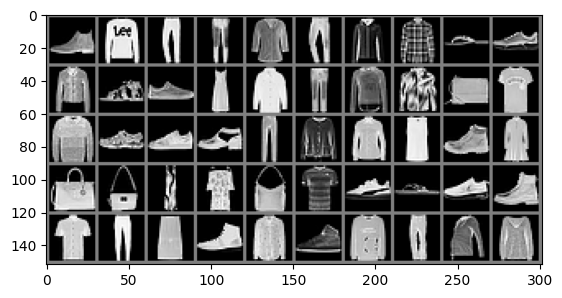

Stitched VAE reconstruction:


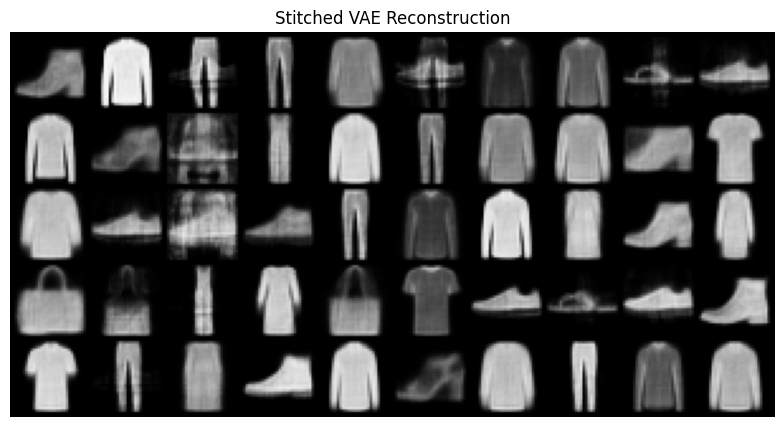

In [14]:
images, _ = next(iter(test_loader))
# --- View original images ---
print('Original images')
show_image(torchvision.utils.make_grid(images[:50], nrow=10, padding=2, normalize=False))

# --- reconstructions with the 'stitched' model ---
print('Stitched VAE reconstruction:')
visualise_output(images, stitched_vae, "Stitched VAE Reconstruction")


Original images


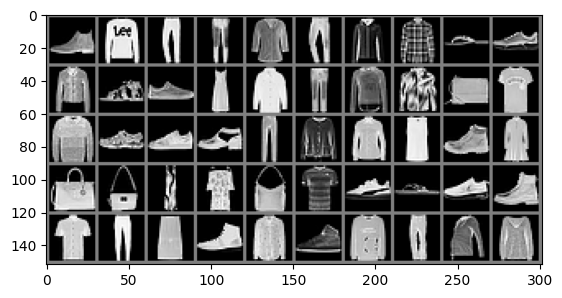

VAE1 reconstruction:


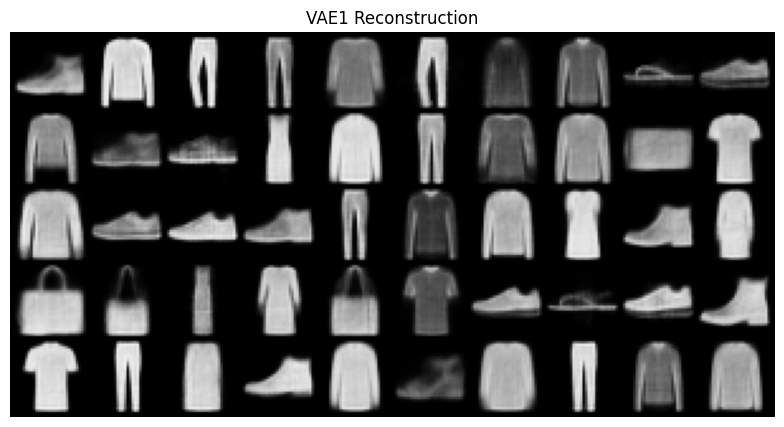

VAE2 reconstruction:


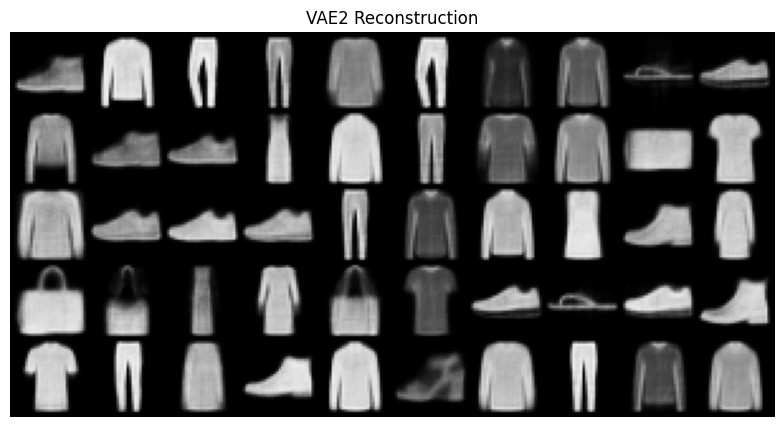

In [6]:
# ---  original images ---
print('Original images')
show_image(torchvision.utils.make_grid(images[:50], nrow=10, padding=2, normalize=False))

# --- reconstructions of the first VAE ---
print('VAE1 reconstruction:')
visualise_output(images, vae1, "VAE1 Reconstruction")

# --- reconstructions of the second VAE ---
print('VAE2 reconstruction:')
visualise_output(images, vae2, "VAE2 Reconstruction")